In [1]:
import json
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import mahalanobis

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
def plot_img(img, show_by_cv = False):
    if not show_by_cv:
        fig=plt.figure(figsize=(10, 8))
        _img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(_img)
        plt.show()
    else:
        cv2.imshow("img", img)

In [4]:
def draw_bbox(img, bbox):
    np_bbox = np.array(bbox).reshape(1, 4).flatten()
    cv2.rectangle(img, np_bbox[0:2], np_bbox[0:2] + np_bbox[2:4],
              color=(0, 255, 0), thickness=1)
    return img

#### load created dataset

In [5]:
with open("dataset_keypoints/dataset_final_train_0017.json", "r") as f:
    content = f.read()
dataset = json.loads(content)

#### Image Path

In [6]:
frames = "/home/eam/KittiDs/data_tracking_image_2/training/image_02/0017"

In [7]:
tracklet_indices = np.load("tracklet_indices.npy")[:-1]
tracklet_indices

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 3, 2, 1, 2, 2, 2, 2, 4, 4, 4,
       6, 6, 6, 6, 7, 6, 5, 5, 6, 5, 5, 6, 5, 6, 4, 6, 7, 5, 5, 5, 7])

In [8]:
bboxes = []
cnt = 0
for step in dataset:
    if cnt < len(tracklet_indices):
        track_index = tracklet_indices[cnt]
        obj = step["objects"][track_index]
        bboxes.append(obj["bbox"])
    else:
        break
    cnt +=1

In [9]:
assert len(bboxes) == len(tracklet_indices)

In [10]:
from numpy.random import randn

std_x, std_y = .3, .3
zs = [np.array([i + randn()*std_x, 
                i + randn()*std_y]) for i in range(100)] 

In [11]:
bboxes_center = np.array([[x[0] + int(x[2]/2), x[1] + int(x[3]/2)] for x in bboxes])
print(bboxes[0])
print(bboxes_center[0])

[384, 149, 108, 210]
[438 254]


In [12]:
from filterpy.kalman import JulierSigmaPoints
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import Q_discrete_white_noise


def f_cv(x, dt):
    """ state transition function for a 
    constant velocity aircraft"""
#     print("measurement", x)
    F = np.array([[1, dt, 0,  0],
                  [0,  1, 0,  0],
                  [0,  0, 1, dt],
                  [0,  0, 0,  1]])
    
    return F @ x

def h_cv(x):
    return x[[0, 2]]

dt = 0.1
sigmas = MerweScaledSigmaPoints(4, alpha=.1, beta=2., kappa=1.)
ukf = UKF(dim_x=4, dim_z=2, fx=f_cv,
          hx=h_cv, dt=dt, points=sigmas)
ukf.x = np.array([bboxes_center[0,0], 0., bboxes_center[0,1], 0.])
ukf.R = np.diag([0.09, 0.09]) 
ukf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=1, var=0.02)
ukf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=1, var=0.02)



In [13]:
uxs = []

for i in range(len(bboxes_center)-1):
    ukf.predict()
    ukf.update(bboxes_center[i+1])
    uxs.append(ukf.x.copy())
uxs = np.array(uxs)


In [26]:
bboxes_center

array([[ 438,  254],
       [ 442,  256],
       [ 457,  256],
       [ 477,  255],
       [ 493,  256],
       [ 499,  256],
       [ 505,  260],
       [ 522,  258],
       [ 540,  257],
       [ 560,  257],
       [ 575,  261],
       [ 587,  261],
       [ 593,  260],
       [ 609,  259],
       [ 631,  257],
       [ 634,  258],
       [ 641,  263],
       [ 651,  263],
       [ 670,  262],
       [ 698,  257],
       [ 714,  257],
       [ 728,  261],
       [ 749,  260],
       [ 754,  259],
       [ 767,  258],
       [ 796,  255],
       [ 797,  255],
       [ 813,  257],
       [ 821,  260],
       [ 857,  258],
       [ 885,  257],
       [ 914,  256],
       [ 927,  256],
       [ 946,  259],
       [ 973,  257],
       [1011,  255],
       [1021,  255],
       [1051,  254],
       [1089,  253],
       [1121,  255],
       [1150,  253],
       [1163,  255],
       [1181,  258]])

In [14]:
plt.rcParams["figure.figsize"] = (9, 4)

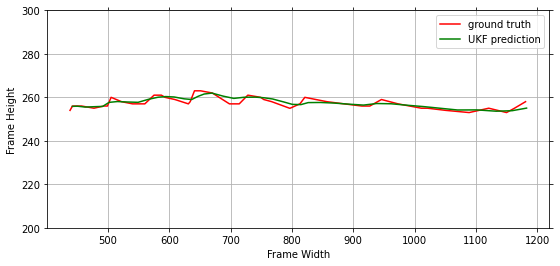

In [16]:
plt.cla()
plt.plot(bboxes_center[:, 0], bboxes_center[:, 1],'r', label='ground truth')
plt.plot(uxs[:, 0], uxs[:, 2], 'g', label='UKF prediction')
x1,x2,y1,y2 = plt.axis()  
plt.axis((x1,x2,200,300))
plt.legend()
plt.xlabel("Frame Width")
plt.ylabel("Frame Height")
plt.grid()
plt.savefig('person_x_tracking.pdf', bbox_inches='tight')
plt.show()

## Track 3D the CCS (track points in pixel)

In [46]:
def read_calib_file(filepath):
    """
    Read in a calibration file and parse into a dictionary.
    Ref: https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py
    """
    data = {}
    with open(filepath, 'r') as f:
        for line in f.readlines():
            line = line.rstrip()
            if len(line) == 0: continue
            key, value = line.split(':', 1)
            # The only non-float values in these files are dates, which
            # we don't care about anyway
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass

    return data

In [47]:
calib = read_calib_file('/home/mohamad/Kitti_tracking/data_tracking_calib/training/calib/0017.txt')
def Rect_to_p2pixel_transf_f(xyd, calib):
    p2 = calib["P2"].reshape(3,4)
    offs = p2[:,3]

    res = p2[:,:3]@np.array(xyd)
    final = (res+offs)

    #arrXYD = np.array(xyd)

    return final

def P2pixel_to_rect_transf_f(xyd, calib):
    # we can't invert the 3x4 matrix calib["P2"],
    # but since the translative pixel offsets (calib["P2"][:,3]) are static,
    # we can first reverse those, and then multiply with the inverse rotation matrix (np.linalg.inv(calib["P2"][:,:3]))
    p2 = calib["P2"].reshape(3,4)
    offs = p2[:,3]
    arrXYD = np.array(xyd)
    final = (arrXYD-offs)
    return np.linalg.inv(p2[:,:3])@final


In [48]:
def reject_outliers(data, m = 2.):
    """ Reject outliers from distance meaurement
    """
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

In [49]:
bboxes = []
depthes = []
cnt = 0
for step in dataset:
    if cnt < len(tracklet_indices):
        track_index = tracklet_indices[cnt]
        obj = step["objects"][track_index]
        bboxes.append(obj["bbox"])
        lidars_distances = obj["lidars"][2]
        depth = reject_outliers(np.random.choice(lidars_distances, int(len(lidars_distances)/2)), 1.5).mean()
        depthes.append(depth)
    else:
        break
    cnt +=1

In [50]:
bboxes_center = np.array([[x[0] + int(x[2]/2), x[1] + int(x[3]/2)] for x in bboxes])
xyz_ccs = np.append(bboxes_center[:,0:2], np.array(depthes).reshape(len(depthes),-1), axis=1)
print(bboxes_center[0])
print(xyz_ccs[0], " , ", xyz_ccs[-1])
print(np.array([xyz_ccs[0,0], 0., xyz_ccs[0,1], 0., xyz_ccs[0,2], 0.]))

[439 254]
[439.         254.           5.90363636]  ,  [1189.    261.      2.92]
[439.           0.         254.           0.           5.90363636
   0.        ]


In [51]:
from filterpy.kalman import JulierSigmaPoints
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import Q_discrete_white_noise


def f_cv(x, dt):
    """ state transition function for a 
    constant velocity pedestrian"""
#     print("measurement", x)
    # [x vx y vy z vz]
    F = np.array([[1, dt, 0,  0, 0,  0],
                  [0,  1, 0,  0, 0,  0],
                  [0,  0, 1, dt, 0,  0],
                  [0,  0, 0,  1, 0,  0],
                  [0,  0, 0,  0, 1, dt],
                  [0,  0, 0,  0, 0,  1]])
    
    return F @ x

def h_cv(x):
    
    xyz = P2pixel_to_rect_transf_f(np.array([int(x[0]*x[4]), int(x[2]*x[4]), x[4]]), calib)
    #print("h_cv: ", x , " , ", xyz)
    #xyz = Rect_to_p2pixel_transf_f([x[0], x[2], x[4]],calib)/x[4]
    return xyz

dt = 0.1
sigmas = MerweScaledSigmaPoints(6, alpha=0.1, beta=2., kappa=-1.)
ukf = UKF(dim_x=6, dim_z=3, fx=f_cv, hx=h_cv, dt=dt, points=sigmas)

#xyz = P2pixel_to_rect_transf_f(np.array([xyz_ccs[0, 0]*xyz_ccs[0, 2], xyz_ccs[0, 1]*xyz_ccs[0, 2], 1*xyz_ccs[0, 2]]), calib)
ukf.x = np.array([xyz_ccs[0, 0], 0, xyz_ccs[0, 1], 0, xyz_ccs[0, 2], 0])
ukf.R = np.diag([0.001, 0.001, 0.001]) 
#ukf.R = ukf.R @ ukf.R
ukf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.08)
ukf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=dt, var=0.08)
ukf.Q[4:6, 4:6] = Q_discrete_white_noise(2, dt=dt, var=0.08)
ukf.P = np.diag([10000**2, 10**2, 1000**2, 10**2, 1000**2, 10**2])


### Test conversion from ccs to wcs

In [52]:
xyz = P2pixel_to_rect_transf_f(np.array([xyz_ccs[0, 0]*xyz_ccs[0, 2], xyz_ccs[0, 1]*xyz_ccs[0, 2], 1*xyz_ccs[0, 2]]), calib)

print(xyz_ccs[0])
print(xyz)

[439.         254.           5.90363636]
[-1.43883874  0.61540664  5.89865535]


In [53]:
np.set_printoptions(precision=3)
uxs = []

for i in range(len(xyz_ccs)-1):
#     print(xyz_ccs[i+1])
    ukf.predict()
    xyz = P2pixel_to_rect_transf_f(np.array([xyz_ccs[i+1, 0]*xyz_ccs[i+1, 2], xyz_ccs[i+1, 1]*xyz_ccs[i+1, 2], 1*xyz_ccs[i+1, 2]]), calib)
    print("update: ", xyz_ccs[i+1,[0,1,2]], xyz)
    ukf.update(np.array([xyz[0], xyz[1], xyz[2]]))
    uxs.append(ukf.x.copy())
uxs = np.array(uxs)

update:  [443.    256.      5.855] [-1.394  0.627  5.85 ]
update:  [458.    256.      5.818] [-1.263  0.623  5.813]
update:  [477.   255.     5.81] [-1.105  0.614  5.805]
update:  [494.    257.      5.736] [-0.954  0.622  5.731]
update:  [500.    257.      5.683] [-0.897  0.617  5.678]
update:  [505.    261.      5.621] [-0.848  0.642  5.616]
update:  [522.    258.      5.546] [-0.704  0.61   5.541]
update:  [540.    257.      5.563] [-0.565  0.604  5.558]
update:  [560.    259.      5.417] [-0.398  0.603  5.412]
update:  [576.    262.      5.333] [-0.272  0.616  5.328]
update:  [588.    261.      5.291] [-0.181  0.604  5.286]
update:  [594.    261.      5.242] [-0.135  0.599  5.237]
update:  [609.    259.      5.242] [-0.024  0.584  5.237]
update:  [632.    257.      5.219] [0.146 0.566 5.214]
update:  [635.    259.      5.149] [0.165 0.573 5.144]
update:  [642.    263.      5.082] [0.212 0.595 5.077]
update:  [651.    264.      4.969] [0.269 0.589 4.964]
update:  [671.    263.      4

In [54]:
for i in range(xyz_ccs.shape[0]-1):
    print(xyz_ccs[i+1,[0,1,2]], uxs[i,[0,2,4]])

[443.    256.      5.855] [436.309 254.378   5.855]
[458.    256.      5.818] [455.326 258.832   5.814]
[477.   255.     5.81] [464.335 261.646   5.796]
[494.    257.      5.736] [466.832 259.533   5.739]
[500.    257.      5.683] [483.344 257.698   5.675]
[505.    261.      5.621] [490.456 254.742   5.618]
[522.    258.      5.546] [504.544 259.159   5.55 ]
[540.    257.      5.563] [521.106 262.229   5.521]
[560.    259.      5.417] [537.721 253.993   5.446]
[576.    262.      5.333] [555.254 261.904   5.37 ]
[588.    261.      5.291] [572.625 257.58    5.301]
[594.    261.      5.242] [585.782 260.013   5.239]
[609.    259.      5.242] [599.415 260.708   5.199]
[632.    257.      5.219] [614.057 258.463   5.169]
[635.    259.      5.149] [627.005 259.373   5.128]
[642.    263.      5.082] [639.936 260.41    5.079]
[651.    264.      4.969] [652.833 261.26    5.008]
[671.    263.      4.888] [666.278 261.457   4.931]
[699.  257.    4.8] [686.39  260.761   4.848]
[715.    258.      4.

In [55]:
xyz_ccs[:-1,[0]] -  uxs[:,[0]]
print(np.diff(xyz_ccs[:-1,[0]].reshape(-1,)))
print(np.diff(uxs[:,[0]].reshape(-1, )))

[ 4. 15. 19. 17.  6.  5. 17. 18. 20. 16. 12.  6. 15. 23.  3.  7.  9. 20.
 28. 16. 13. 22.  5. 14. 29. -1. 16.  9. 35. 28. 30. 12. 20. 26. 39.  9.
 31. 39. 30. 30. 13. 18.]
[19.016  9.009  2.497 16.512  7.112 14.088 16.563 16.615 17.533 17.371
 13.157 13.633 14.642 12.948 12.931 12.897 13.445 20.112 16.926 16.332
 17.049 13.896 14.603 17.344 13.784 14.165 13.777 15.975 17.244 18.578
 15.444 17.087 17.792 17.546 21.464 17.873 18.358 23.644 17.25  23.563
 23.473 23.279]


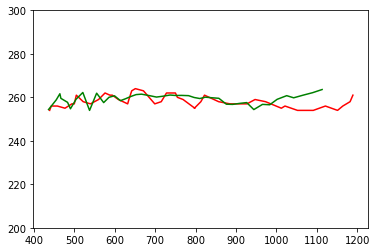

In [56]:
plt.plot(xyz_ccs[:, 0], xyz_ccs[:, 1],'r')
plt.plot(uxs[:, 0], uxs[:, 2], 'g')
x1,x2,y1,y2 = plt.axis()  
plt.axis((x1,x2,200,300))
plt.show()

In [57]:
Rect_to_p2pixel_transf_f([2.35,  0.334, 2.909], calib)/2.909

array([1.191e+03, 2.616e+02, 1.002e+00])

## Track 3D + Aspect ratio + height (in CCS)

In [58]:
bboxes_center = np.array([[x[0] + int(x[2]/2), x[1] + int(x[3]/2)] for x in bboxes])
ar_h = np.array([[x[2]/x[3], int(x[3])] for x in bboxes])
xyz_ccs = np.append(bboxes_center[:,0:2], np.array(depthes).reshape(len(depthes),-1), axis=1)

# xc, yc, zc, aspect_ratio, height
all_info = np.append(xyz_ccs[:,0:3], ar_h[:,0:2],axis=1)


In [59]:
# [x vx y vy z vz a va h va]
# a = w/h => w = h.a

from filterpy.kalman import JulierSigmaPoints
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import Q_discrete_white_noise


def f_cv(x, dt):
    """ state transition function for a 
    constant velocity pedestrian"""
#     print("measurement", x)
    # [x vx y vy z vz a va h va]
    F = np.array([[1, dt, 0,  0, 0,  0, 0,  0, 0,  0],
                  [0,  1, 0,  0, 0,  0, 0,  0, 0,  0],
                  [0,  0, 1, dt, 0,  0, 0,  0, 0,  0],
                  [0,  0, 0,  1, 0,  0, 0,  0, 0,  0],
                  [0,  0, 0,  0, 1, dt, 0,  0, 0,  0],
                  [0,  0, 0,  0, 0,  1, 0,  0, 0,  0],
                  [0,  0, 0,  0, 0,  0, 1, dt, 0,  0],
                  [0,  0, 0,  0, 0,  0, 0,  1, 0,  0],
                  [0,  0, 0,  0, 0,  0, 0,  0, 1, dt],
                  [0,  0, 0,  0, 0,  0, 0,  0, 0,  1]])
    
    return F @ x

def h_cv(x):
    
    xyz = P2pixel_to_rect_transf_f(np.array([int(x[0]*x[4]), int(x[2]*x[4]), x[4]]), calib)
    #print("h_cv: ", x , " , ", xyz)
    #xyz = Rect_to_p2pixel_transf_f([x[0], x[2], x[4]],calib)/x[4]
    final = np.append(xyz, [x[6],x[8]])
    #print(final)
    return final

dt = 0.1
sigmas = MerweScaledSigmaPoints(10, alpha=0.1, beta=2., kappa=-1.)
ukf = UKF(dim_x=10, dim_z=5, fx=f_cv, hx=h_cv, dt=dt, points=sigmas)

#xyz = P2pixel_to_rect_transf_f(np.array([xyz_ccs[0, 0]*xyz_ccs[0, 2], xyz_ccs[0, 1]*xyz_ccs[0, 2], 1*xyz_ccs[0, 2]]), calib)
ukf.x = np.array([all_info[0, 0], 0, all_info[0, 1], 0, all_info[0, 2], 0, all_info[0, 3], 0, all_info[0, 4], 0])
ukf.R = np.diag([0.001, 0.001, 0.001, 0.001, 0.001]) 
#ukf.R = ukf.R @ ukf.R
ukf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.08)
ukf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=dt, var=0.08)
ukf.Q[4:6, 4:6] = Q_discrete_white_noise(2, dt=dt, var=0.08)
ukf.Q[6:8, 6:8] = Q_discrete_white_noise(2, dt=dt, var=0.08)
ukf.Q[8:10, 8:10] = Q_discrete_white_noise(2, dt=dt, var=0.08)
ukf.P = np.diag([10000**2, 10**2, 1000**2, 10**2, 1000**2, 10**2, 1000**2, 10**2, 1000**2, 10**2])

In [60]:
uxs = []

for i in range(len(all_info)):
    ukf.predict()
    xyz = P2pixel_to_rect_transf_f(np.array([all_info[i, 0]*all_info[i, 2], all_info[i, 1]*all_info[i, 2], 1*all_info[i, 2]]), calib)
    #print("update: ", xyz_ccs[i+1,[0,1,2]], xyz)
    ukf.update(np.array([xyz[0], xyz[1], xyz[2],all_info[i, 3],all_info[i, 4]]))
    uxs.append(ukf.x.copy())
uxs = np.array(uxs)

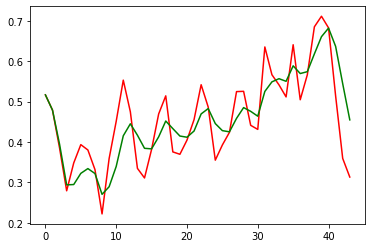

In [61]:

plt.plot(all_info[:,[3]],'r')
plt.plot(uxs[:, [6]], 'g')
x1,x2,y1,y2 = plt.axis()  
#plt.axis((x1,x2,200,300))
plt.show()

## Track 3D in WCS

In [390]:
bboxes_center = np.array([[x[0] + int(x[2]/2), x[1] + int(x[3]/2)] for x in bboxes])
ar_h = np.array([[x[2]/x[3], int(x[3])] for x in bboxes])
xyz_ccs = np.append(bboxes_center[:,0:2], np.array(depthes).reshape(len(depthes),-1), axis=1)

# xc, yc, zc, aspect_ratio, height
all_info = np.append(xyz_ccs[:,0:3], ar_h[:,0:2],axis=1)

In [391]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [392]:
# [x vx y vy z vz a va h va]
# a = w/h => w = h.a

from filterpy.kalman import JulierSigmaPoints
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import Q_discrete_white_noise


def f_cv(x, dt):
    """ state transition function for a 
    constant velocity pedestrian"""
#     print("measurement", x)
    # [x vx y vy z vz a va h va]
    F = np.array([[1, dt, 0,  0, 0,  0, 0,  0, 0,  0],
                  [0,  1, 0,  0, 0,  0, 0,  0, 0,  0],
                  [0,  0, 1, dt, 0,  0, 0,  0, 0,  0],
                  [0,  0, 0,  1, 0,  0, 0,  0, 0,  0],
                  [0,  0, 0,  0, 1, dt, 0,  0, 0,  0],
                  [0,  0, 0,  0, 0,  1, 0,  0, 0,  0],
                  [0,  0, 0,  0, 0,  0, 1, dt, 0,  0],
                  [0,  0, 0,  0, 0,  0, 0,  1, 0,  0],
                  [0,  0, 0,  0, 0,  0, 0,  0, 1, dt],
                  [0,  0, 0,  0, 0,  0, 0,  0, 0,  1]])
    
    return F @ x

def h_cv(x):
    
    xyz = Rect_to_p2pixel_transf_f(np.array([x[0], x[2], x[4]]), calib) / x[4]
    #print("h_cv: ", x , " , ", xyz)
    #xyz = Rect_to_p2pixel_transf_f([x[0], x[2], x[4]],calib)/x[4]
    final = np.append(xyz, [x[6],x[8]])
#     print("h_cv:", x)
#     print("h_cv:",final)
#     print("_____________________________________")
    return final

In [393]:
dt = 0.1
sigmas = MerweScaledSigmaPoints(10, alpha=0.2, beta=2., kappa=-7.)
ukf = UKF(dim_x=10, dim_z=5, fx=f_cv, hx=h_cv, dt=dt, points=sigmas)

xyz = P2pixel_to_rect_transf_f(np.array([all_info[0, 0]*all_info[0, 2], all_info[0, 1]*all_info[0, 2], 1*all_info[0, 2]]), calib)
ukf.x = np.array([xyz[0], 0, xyz[1], 0, xyz[2], 0, all_info[0, 3], 0, all_info[0, 4], 0])
ukf.R = np.diag([1000, 1000, 0.09,0.09, 1000]) 
#ukf.R = ukf.R @ ukf.R
ukf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
ukf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=dt, var=0.1)
ukf.Q[4:6, 4:6] = Q_discrete_white_noise(2, dt=dt, var=0.1)
ukf.Q[6:8, 6:8] = Q_discrete_white_noise(2, dt=dt, var=0.1)
ukf.Q[8:10, 8:10] = Q_discrete_white_noise(2, dt=dt, var=0.1)
#ukf.P = np.diag([1000**2, 3**2, 100**2, 3**2, 100**2, 3**2, 100**2, 3**2, 100**2, 3**2])
ukf.x

array([ -1.439,   0.   ,   0.615,   0.   ,   5.899,   0.   ,   0.517,
         0.   , 211.   ,   0.   ])

In [394]:
wcs_points = []
for point in all_info:
    xyz_wcs = P2pixel_to_rect_transf_f(np.array([point[0]*point[2], point[1]*point[2], 1*point[2]]), calib)
    wcs_points.append(xyz_wcs)
wcs_points = np.array(wcs_points)

In [395]:
uxs = []

for i in range(len(all_info)):
    ukf.predict()
    #xyz = P2pixel_to_rect_transf_f(np.array([all_info[i, 0]*all_info[i, 2], all_info[i, 1]*all_info[i, 2], 1*all_info[i, 2]]), calib)
    print("update: ", all_info[i,0], all_info[i, 1], all_info[i, 2],all_info[i, 3],all_info[i, 4])
    print("X bef:", ukf.x)
    ukf.update(np.array([all_info[i,0], all_info[i, 1], all_info[i, 2],all_info[i, 3],all_info[i, 4]]))
    print("X aft:", ukf.x)
    uxs.append(ukf.x.copy())
    print("SI:", ukf.SI.shape)
    print("MN dist:", ukf.mahalanobis)
    
    next_xyz = P2pixel_to_rect_transf_f(np.array([all_info[i, 0]*all_info[i, 2], all_info[i, 1]*all_info[i, 2], 1*all_info[i, 2]]), calib)
    next_step = np.array([next_xyz[0], 0, next_xyz[1], 0, next_xyz[2], 0, all_info[i, 3], 0, all_info[i, 4], 0])
    print(ukf.x[[0,2,4,6,8]])
    print(next_step[[0,2,4,6,8]])
    mahalanobis_dist = mahalanobis(ukf.x[[0,2,4,6,8]], next_step[[0,2,4,6,8]], ukf.SI)
    print("MN dist1:", mahalanobis_dist)
    #print(np.sqrt())
    #print(ukf.SI)
uxs = np.array(uxs)

update:  439.0 254.0 5.903636363636363 0.5165876777251185 211.0
X bef: [ -1.439   0.      0.615   0.      5.899   0.      0.517   0.    211.
   0.   ]
X aft: [ -1.405   0.003   0.597  -0.002   5.901   0.      0.517  -0.    211.
   0.   ]
SI: (5, 5)
MN dist: 16.342607302571437
[ -1.405   0.597   5.901   0.517 211.   ]
[ -1.439   0.615   5.899   0.517 211.   ]
MN dist1: 0.006581897319343627
update:  443.0 256.0 5.85475 0.4788732394366197 213.0
X bef: [ -1.404   0.003   0.597  -0.002   5.901   0.      0.517  -0.    211.
   0.   ]
X aft: [ -1.404   0.002   0.613   0.022   5.892  -0.004   0.497  -0.022 211.002
   0.   ]
SI: (5, 5)
MN dist: 16.180193179490022
[ -1.404   0.613   5.892   0.497 211.002]
[ -1.394   0.627   5.85    0.479 213.   ]
MN dist1: 0.15979371807050755
update:  458.0 256.0 5.8184375 0.38497652582159625 213.0
X bef: [ -1.404   0.002   0.615   0.022   5.891  -0.004   0.495  -0.022 211.002
   0.   ]
X aft: [ -1.348   0.14    0.621   0.037   5.893   0.023   0.449  -0.125 211.0

In [312]:
uxs[:,8], all_info[:,4]

(array([211.   , 211.002, 211.004, 210.996, 211.012, 211.02 , 211.023,
        211.044, 211.07 , 211.091, 211.104, 211.122, 211.143, 211.178,
        211.229, 211.269, 211.286, 211.3  , 211.318, 211.328, 211.358,
        211.38 , 211.42 , 211.488, 211.52 , 211.59 , 211.649, 211.76 ,
        211.827, 211.861, 211.943, 211.959, 212.131, 212.224, 212.309,
        212.397, 212.525, 212.644, 212.767, 212.879, 212.936, 213.023,
        213.126, 213.231]),
 array([211., 213., 213., 204., 224., 216., 213., 223., 225., 220., 215.,
        217., 217., 221., 225., 220., 213., 212., 213., 211., 215., 213.,
        216., 220., 214., 219., 217., 223., 217., 213., 218., 211., 226.,
        218., 217., 217., 220., 219., 219., 218., 214., 216., 217., 217.]))